In [1]:
import sys
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interactive, IntSlider

import numpy as np
import pandas as pd
import sqlite3
import torch

In [3]:
sys.path.append(os.path.join(sys.path[0], '../../..'))

from endure.data.io import Reader
from endure.lsm.cost import EndureCost
from endure.lsm.types import Policy, System, LSMDesign, LSMBounds, Workload
from endure.ltune.util import LTuneEvalUtil
from endure.ltune.model import LTuneModelBuilder

In [6]:
connection = sqlite3.connect("/scratchNVMe/axe/db/yzlsm/mlos_exp_yz.db")
cursor = connection.cursor()

In [7]:
env_table = pd.read_sql("SELECT * FROM environments;", connection, index_col="env_id")
run_table = pd.read_sql("SELECT * FROM tunings;", connection, index_col="idx")

In [8]:
WL_COLUMNS = ['empty_reads', 'non_empty_reads', 'range_queries', 'writes']
SYS_COLUMNS = ['entry_size', 'selectivity', 'entries_per_page', 'num_elmement', 'bits_per_elem_max', 'read_write_asym']

In [9]:
env_table.head(10)

,empty_reads,non_empty_reads,range_queries,writes,entry_size,selectivity,entries_per_page,num_elmement,bits_per_elem_max,read_write_asym
env_id,,,,,,,,,,
1,0.25,0.25,0.25,0.25,8192,4.000000e-07,4,1000000000,10.0,1.0
2,0.97,0.01,0.01,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0
3,0.01,0.97,0.01,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0
4,0.01,0.01,0.97,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0
5,0.01,0.01,0.01,0.97,8192,4.000000e-07,4,1000000000,10.0,1.0
6,0.49,0.49,0.01,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0
7,0.49,0.01,0.49,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0
8,0.49,0.01,0.01,0.49,8192,4.000000e-07,4,1000000000,10.0,1.0
9,0.01,0.49,0.49,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0


In [10]:
run_table.head(10)

,env_id,trial,round,bits_per_elem,size_ratio,kap0,kap1,kap2,kap3,kap4,...,kap13,kap14,kap15,kap16,kap17,kap18,kap19,y_val,z_val,cost
idx,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,4.575953,23,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,21,27,39.625643
2,1,0,1,7.355913,11,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8,7,32.446881
3,1,0,2,7.814212,31,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29,22,42.466737
4,1,0,3,1.696480,5,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,13,31.468264
5,1,0,4,3.116324,26,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15,9,34.409712
6,1,0,5,9.233784,8,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,17,18,44.839502
7,1,0,6,6.493652,20,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8,3,30.445678
8,1,0,7,3.713420,16,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25,24,43.454834
9,1,0,8,3.902633,29,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5,16,30.176480


In [11]:
run_table.query("env_id == 5")

,env_id,trial,round,bits_per_elem,size_ratio,kap0,kap1,kap2,kap3,kap4,...,kap13,kap14,kap15,kap16,kap17,kap18,kap19,y_val,z_val,cost
idx,,,,,,,,,,,,,,,,,,,,,
40001,5,0,0,8.159221,21,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3,13,5.358890
40002,5,0,1,3.218739,9,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,16,21,2.801369
40003,5,0,2,3.330907,29,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14,8,2.905209
40004,5,0,3,7.161072,16,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,27,28,2.891549
40005,5,0,4,6.458106,25,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,22,26,2.779906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,5,99,95,5.769131,10,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,23,16,2.889337
49997,5,99,96,1.000036,30,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30,2,2.609125
49998,5,99,97,1.000036,30,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,27,2,2.599793


In [12]:
run_table.describe()

,env_id,trial,round,bits_per_elem,size_ratio,kap0,kap1,kap2,kap3,kap4,...,kap13,kap14,kap15,kap16,kap17,kap18,kap19,y_val,z_val,cost
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.0,150000.0,150000.0,150000.0,150000.0,...,150000.0,150000.0,150000.0,150000.0,150000.0,150000.0,150000.0,150000.000000,150000.000000,150000.000000
mean,8.000000,49.500000,49.500000,5.203827,17.520973,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.938387,7.654027,31.930834
std,4.320508,28.866166,28.866166,2.760388,9.428165,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.077735,8.606341,35.128960
min,1.000000,0.000000,0.000000,1.000000,2.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.157506
25%,4.000000,24.750000,24.750000,2.774071,9.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,2.632580
50%,8.000000,49.500000,49.500000,5.146103,16.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.000000,3.000000,28.482313
75%,12.000000,74.250000,74.250000,7.666501,27.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,16.000000,13.000000,50.660178
max,15.000000,99.000000,99.000000,9.899839,31.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.000000,30.000000,460.178842


# Load in LTune Model

In [13]:
path = '/scratchNVMe/axe/models/ltune/yzlsm'
config = Reader.read_config(os.path.join(path, 'endure.toml'))
design_type = getattr(Policy, config["lsm"]["design"])
bounds = LSMBounds(**config["lsm"]["bounds"])
cf = EndureCost(bounds.max_considered_levels)

In [14]:
model = LTuneModelBuilder(
    size_ratio_range=bounds.size_ratio_range,
    max_levels=bounds.max_considered_levels,
    **config["ltune"]["model"],
).build_model(design_type)
model_name = os.path.join(path, 'best.model')
# model_name = os.path.join(path, 'checkpoints/epoch_14.checkpoint')
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
status = model.load_state_dict(model_params)
model.eval()
status

<All keys matched successfully>

In [15]:
ltune_util = LTuneEvalUtil(config, model, design_type)

## Example of how to evaluate ltune

In [16]:
z0, z1, q, w = workload = ltune_util.gen._sample_workload(4)
system = ltune_util.gen._sample_system()
out = ltune_util.get_ltune_out(system, z0, z1, q, w)
design = ltune_util.convert_ltune_output(out)

# Plotting Experiments


1. Train a LTune model
2. Start with a clean BO model
3. Pick a workload, w, that both models have not seen
4. Train BO model, while capturing the designs at each round (round <- (suggest, cost, register))
5. Plot performance of each round, and the performance of a single LTune suggestion for w

## Parameters

Change run_id to look at a different environment setup

In [17]:
def add_learned_tunings(con: sqlite3.Connection) -> None:
    cursor = con.cursor()
    cursor.execute(
        """
        CREATE TABLE IF NOT EXISTS learned_tunings (
            env_id INTEGER PRIMARY KEY AUTOINCREMENT,
            bits_per_elem REAL,
            size_ratio INTEGER,
            y_val INTEGER,
            z_val INTEGER
            cost REAL,
            FOREIGN KEY (env_id) REFERENCES workloads(env_id)
        );
        """
    )
    environment_ids = cursor.execute("SELECT env_id FROM environments").fetchall()
    for (env_id,) in environment_ids:
        env = env_table.query(f'env_id == {env_id}')
        data = run_table.query(f'env_id == {env_id}')
        wl = Workload(*env[WL_COLUMNS].values[0])
        system = System(*env[SYS_COLUMNS].values[0])
        with torch.no_grad():
            out = ltune_util.get_ltune_out(system, wl.z0, wl.z1, wl.q, wl.w, hard=True)
        ltune_design = ltune_util.convert_ltune_output(out)
        ltune_cost = cf.calc_cost(ltune_design, system, wl.z0, wl.z1, wl.q, wl.w)
        cursor.execute(
            """
            INSERT OR REPLACE INTO learned_tunings (
            env_id,
            bits_per_elem,
            size_ratio,
            y_val,
            z_val,
            cost
            ) VALUES (?, ?, ?, ?, ?, ?)
            """,
            (env_id, ltune_design.h, int(ltune_design.T), int(ltune_design.Y), int(ltune_design.Z), ltune_cost,)
        )
    cursor.close()
    con.commit()
    
    ltune_table = pd.read_sql("SELECT * FROM learned_tunings;", con, index_col="env_id")
    return ltune_table

In [18]:
ltune_table = add_learned_tunings(connection)
# ltune_table = pd.read_sql("SELECT * FROM learned_tunings;", connection, index_col="env_id")
ltune_table

,bits_per_elem,size_ratio,y_val,z_val,cost
env_id,,,,,
1,0.108020,8,1,1,28.079363
2,4.928157,15,4,1,1.289037
3,4.411879,15,2,1,2.103687
4,0.149961,25,1,1,99.178532
5,1.708495,3,6,3,3.500041
6,4.626106,15,4,1,1.726375
7,0.530475,25,1,1,50.623683
8,4.417707,3,6,1,3.001783
9,0.349896,8,1,1,51.227943


In [19]:
def plot_env(env_id: int = 1):
    env = env_table.query(f'env_id == {env_id}')
    data = run_table.query(f'env_id == {env_id}')
    learned_tuning = ltune_table.query(f'env_id == {env_id}')
    wl = Workload(*env[WL_COLUMNS].values[0])
    system = System(*env[SYS_COLUMNS].values[0])
    ltune_cost = learned_tuning.cost.values[0]
    
    group = run_table.query(f'env_id == {env_id}').groupby("round")['cost'].agg(['mean', 'std', 'count'])
    group = group.reset_index()
    group['ci'] = 1.96 * group['std'] / np.sqrt(group['count'])
    group['ci_lower'] = group['mean'] - group['ci']
    group['ci_upper'] = group['mean'] + group['ci']
    
    fig, ax = plt.subplots()
    ax.plot(group['round'], group['mean'], label='Bayesian Optimizer', color='tab:gray', marker='o')
    ax.fill_between(group['round'], group['ci_lower'], group['ci_upper'], color='tab:gray', alpha=.25)
    ax.hlines(y=ltune_cost, xmin=0, xmax=group['round'].values.max(), label='LTune', color='tab:green', linestyle='--')
    ax.legend()
    ax.set_ylabel('Estimate Cost (Avg I/O per Query)')
    ax.set_xlabel('Rounds')
    ax.set_title(f'Workload(z0={wl.z0:.2f}, z1={wl.z1:.2f}, q={wl.q:.2f}, w={wl.w:.2f})')
    plt.show()

    return env_id, learned_tuning, wl, system, fig, ax

In [20]:
def plot_cumulative_env(env_id: int = 1):
    env = env_table.query(f'env_id == {env_id}')
    data = run_table.query(f'env_id == {env_id}')
    learned_tuning = ltune_table.query(f'env_id == {env_id}')
    wl = Workload(*env[WL_COLUMNS].values[0])
    system = System(*env[SYS_COLUMNS].values[0])
    ltune_cost = learned_tuning.cost.values
    
    x, y = data['round'].values, data['cost'].values
    aggregated_cost = []
    tmp = []
    for i in range(1, len(data['cost'].values)):
        aggregated_cost.append(sum(data['cost'].values[:i]))
    aggregated_cost.append(data['cost'].values[i]+aggregated_cost[i-1])

    ltune_aggregated_cost = ltune_cost * np.arange(1, len(x) + 1)
    fig, ax = plt.subplots()
    ax.plot(x, aggregated_cost, label='Bayesian Optimizer (Aggregated)', color='tab:gray')
    ax.plot(x, ltune_aggregated_cost, label='LTune (Aggregated)', color='tab:green', linestyle='--')
    ax.legend()
    ax.set_ylabel('Aggregated Cost (Avg I/O per Query)')
    ax.set_xlabel('Rounds')
    ax.set_title(f'Workload(z0={wl.z0:.2f}, z1={wl.z1:.2f}, q={wl.q:.2f}, w={wl.w:.2f})')
    plt.show()

    return env_id, ltune_design, wl, system, fig, ax

In [21]:
id_widget = IntSlider(min=1, max=len(env_table), step=1)
iplot_env = interactive(plot_env, env_id=id_widget)
iplot_env

interactive(children=(IntSlider(value=1, description='env_id', max=15, min=1), Output()), _dom_classes=('widge…

In [22]:
# for idx in range(1, len(env_table) + 1):
#     id, design, wl, system, fig, ax = plot_env(idx)
#     fig.savefig(f'/home/ndhuynh/transfer/wls/workload_{idx:02d}')

In [23]:
# id_widget = IntSlider(min=1, max=len(env_table), step=1)
# iplot_cum = interactive(plot_cumulative_env, env_id=id_widget)
# iplot_cum

# Analyzing Trends

1. The first graph is a simple cutoff, we count the rounds up until Bayesian Optimization provides a configuration that is lower in expected cost than the design provided by LTune.

2. TODO: Come up with window criteria

In [24]:
# sql_query = """
#     SELECT
#         t.env_id,
#         t.trial,
#         MIN(t.round) as min_round
#     FROM tunings t
#     INNER JOIN learned_tunings lt ON t.env_id = lt.env_id
#     WHERE t.cost < lt.cost
#     GROUP BY t.env_id, t.trial;
#     """
# df = pd.read_sql(sql_query, connection)
# potential_total = pd.read_sql("SELECT COUNT(*) FROM (SELECT DISTINCT env_id, trial FROM tunings)", connection).values[0][0]
# data = df['min_round'].values
# data = np.concatenate([data, [float('inf') for _ in range(potential_total - len(data))]])

# fig, ax = plt.subplots()
# ax.ecdf(data, label="CDF", complementary=False)
# ax.set_xlabel("BO Rounds")
# ax.set_ylabel("Probability of Occurence")
# ax.set_title("Rounds Once BO Outperforms LTune")
# ax.grid()
# plt.show()

In [25]:
def plot_windowing_cdf(window_size=1):
    data = []
    for (env_id, trial), group in run_table.groupby(['env_id', 'trial']):
        valid_idx = group.cost.le(ltune_table.query(f'env_id == {env_id}').cost.values[0]) \
                         .rolling(window_size).min().fillna(0) \
                         .to_numpy().nonzero()[0]
        data.append(float('inf') if len(valid_idx) == 0 else valid_idx[0])
    fig, ax = plt.subplots()
    ax.ecdf(data, label="CDF", complementary=False)
    ax.set_xlabel("Round $i$")
    ax.set_ylabel(f"$P[\omega_{{{window_size},i}}]$", size=12)
    ax.grid()
    plt.show()

    return fig, ax, data

In [26]:
window_size_widget = IntSlider(min=1, max=10, step=1)
iplot_cdf = interactive(plot_windowing_cdf, window_size=window_size_widget)
iplot_cdf

interactive(children=(IntSlider(value=1, description='window_size', max=10, min=1), Output()), _dom_classes=('…

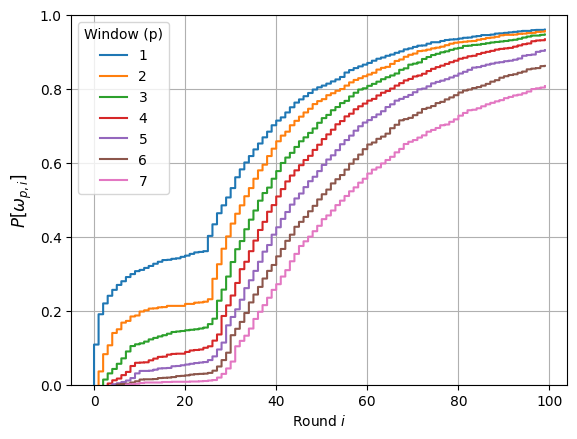

In [27]:
fig, ax = plt.subplots()
for window_size in range(1, 8):
    data = []
    for (env_id, trial), group in run_table.groupby(['env_id', 'trial']):
        valid_idx = group.cost.le(ltune_table.query(f'env_id == {env_id}').cost.values[0]) \
                         .rolling(window_size).min().fillna(0) \
                         .to_numpy().nonzero()[0]
        data.append(float('inf') if len(valid_idx) == 0 else valid_idx[0])
    ax.ecdf(data, label=f"{window_size}", complementary=False)
    
ax.set_xlabel("Round $i$")
ax.set_ylabel("$P[\omega_{p,i}]$", size=12)
ax.grid()
ax.legend(title="Window (p)")
plt.show()

In [26]:
# window_size = 1
# window_values = run_table.groupby(['env_id', 'trial']).cost.apply(
#     lambda x: (x.le(ltune_table.query(f'env_id == {x.name[0]}').cost.values[0])
#                .rolling(window_size) # Calculate over a rolling window size
#                .min().fillna(0) # Find all sequences in `window_size` that is all True (cost < cost_ltune)
#                .argmax())       # argmax to find the first index that satisfies window size
# ).replace(0, float('inf'))
# data = window_values.values